# Compressive Second Harmonic Generation Imaging

The following is a walk through the reconstruction procedure for compressive second harmonic generation imaging - A technique for 3d tissue imaging with far fewer measurements, based on computational reconstruction.

This file demonstrates the use on real experimenatal data from a custom widefield SHG microscope designed to take compressive measurements.

## Optical Forward Model :

An collimated beam having field of wavelength $\lambda_1 = $1000 nm (the fundamental) is incident on a chicken tendon tissue sample of thickness $L_z$ = 25 nm. With reference to the field at the starting point of the tissue the fundamental field at depth $z$ is given as:
$$E_i(z) = E_{io}e^{-j\frac{2\pi n_1}{\lambda_1} z}$$
where $n_1 = \langle n(x,y,z;\lambda_1)\rangle$ is the effective refractive index of the tissue material at wavelength $\lambda_1$.

This field interacts nonlinearly with the tissue, to give the second harmonic field, that is phase matched with the fundamental:
$$E_s(z) = E_{io} s(x,y,z) e^{-j\frac{2\pi n_2}{\lambda_2} z}$$,

where $n_2$ is the effective refractive index of the medium at wavelength $\lambda_2 = \lambda_1/2$.

This field now propagates a distance $L_z - z$ by angular spectrum propagation to give the second harmonic field at the end of the tissue:
$$E_s(z \rightarrow L_z) = E_{io} s(x,y,z) e^{-j\frac{2\pi n_2}{\lambda_2} z} * h(x,y,z)$$
where h(x,y,z) is a filter given by fourier optics/angular spectrum propagation:
$\hat{h}(\nu_x, \nu_y, z) = \exp\left({ -j2\pi (L_z-z) \sqrt{\frac{n_2^2}{\lambda_2^2} - \nu_x^2 - \nu_y^2)}}\right)$

The sum of all such SHG components originating at different $z$ depths give the total SHG field:
$$E_s(L_z) = \sum_z E_{io} s(x,y,z) e^{-j\frac{2\pi n_2}{\lambda_2} z} * h(x,y,z)$$


This can be seen as a linear transfer function from the 3D distribution $s$ to the final electric fiel $E_s$.
If $s$, $b_s$ are the vectorized versions of the 3d distribution $s$ and the field $E_s$ respectively, and if the linear transfer function is given by $H$, then the above can be rewritten as:
$$b_s = Hs$$
This field is now passed through a 4f system, with a $\pm 1$ binary phase mask at the fourier plane. 
$$b_d = F(M(F(b_s)))$$
Here, $F$ represents the 2d fourier operator, and $M$ reperesents the random binary phase mask.
Hence, the net transfer function is written as
$$b_d = FMFHs = As$$.
This field is now detected onto the camera:
$$I_d = |b_d|^2 = |As|^2$$

By changing the phase mask, a different phase modulation can be achieved, and as such several measurements $n_{meas}$ can be taken. 
We solve this problem in two steps:
- Wirtinger flow based phase retrieval in order to get the phase of $y_s$ and $y_d$. This converts the nonlinear problem into a linear problem.
- Regularized iterative least squares to solve the linear problem to give a 3d map $s(x,y,z)$.

In our scheme, the coded apertures serve two purposes: 
- Enable phase retrieval via wirtinger flow [1] based on $n_{meas}$ random intensity measurements.
- Provide decorrelation in the columns of the linear operator $A$ to improve the 3d reconstruction based on sparsity promoting regularization.



We now walk through the high level overview of the reconstruction process. The full code is located at https://github.com/kvarun95/cshg

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
# plt.rcParams.update({'font.size': 22})
from PIL import Image
import importlib
import os
import sys
import scipy.io
from mayavi import mlab

import lasso;from lasso import *
importlib.reload(lasso);from lasso import *
from forward_model import *
from test_wirtinger import *
from mask import *
import utils
from physical_params import *
sys.path.append("../Curvelab/fdct3d/src/")

Define basic parameters

In [3]:
N = 256
NZ = 10
data_dir = "../data/tissue/"
num_masks = 10
mode='amplify'

Load the experimental data

In [4]:
# get the data
I_meas = scipy.io.loadmat(data_dir+"meas.mat")['meas_save']
I_meas = np.transpose(I_meas, (2,0,1))
I_meas[I_meas<0.] = 0.
I_meas = I_meas**2
I_meas = I_meas[:,::-1,::-1]

master = scipy.io.loadmat(data_dir+"masterp.mat")['masterp_save']
master = master[::-1,::-1]
master[master<0.] = 0.

Plot the intensity measurements

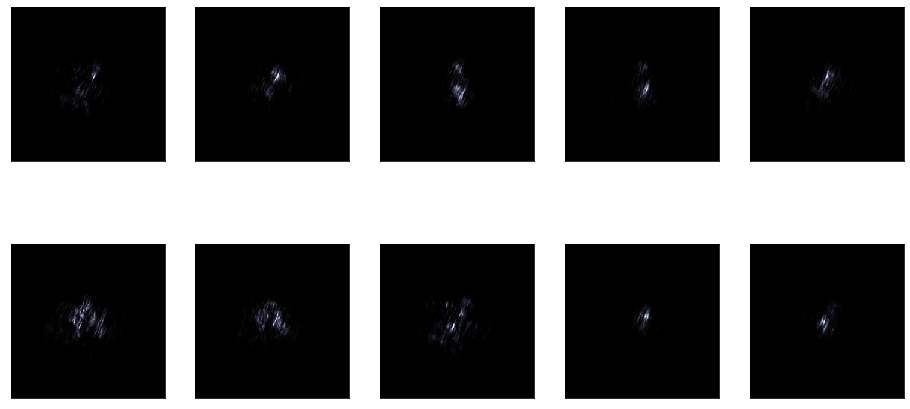

In [5]:
plt.rcParams['figure.figsize'] = 16,8
plt.figure(1)
for i in range(I_meas.shape[0]):
    plt.subplot(2,5,i+1)
    plt.imshow(abs(I_meas[i,:,:]), cmap='bone')
    plt.xticks([])
    plt.yticks([])

Load the coded aperture phase masks

In [6]:
# load masks from mask files
mask_filenames = []
mask_dir = data_dir+"maskth/"
for file in os.listdir(mask_dir):
    if file.endswith(".tif"):
        mask_filenames += [mask_dir+file]
mask_filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        
mask = masks(num_masks, (N,N))

assert len(mask_filenames)==num_masks, "Number of masks does not match number of files"
mask.get_mask(mask_filenames)
# rescale mask between -1 and 1
mask.value = 2 * (mask.value/255.) - 1
mask.value = -mask.value

Run wirtinger flow based reconstruction to get the phase of the measurements and the $b_s$

In [7]:
# final_loss, y_holo, y_meas, _ = wf_real_data_coded_apertures(niter=500, verbose=False):

# get data
y_meas = np.load("../results/ReconCpxField_meas.npy")
y_holo = np.load("../results/ReconCpxField_rplane.npy")

# Normalize it just in case
y_meas = y_meas / abs(y_holo).max()
y_holo = y_holo / abs(y_holo).max()
# y_meas = fwd_op.fourf(y_holo)

Plot magnitude and phase of the measurements, and those of $b_s$

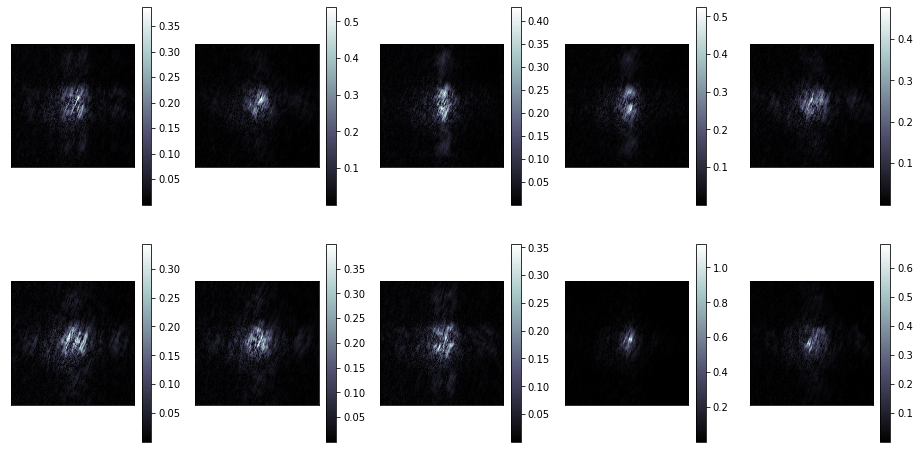

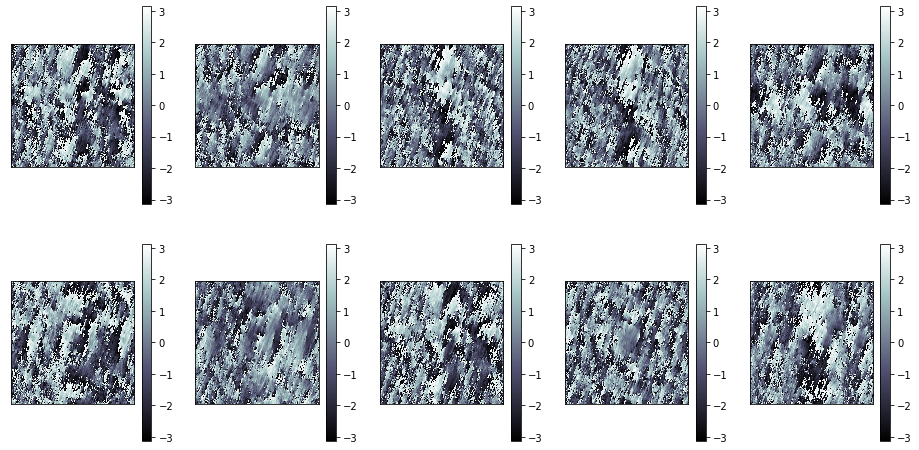

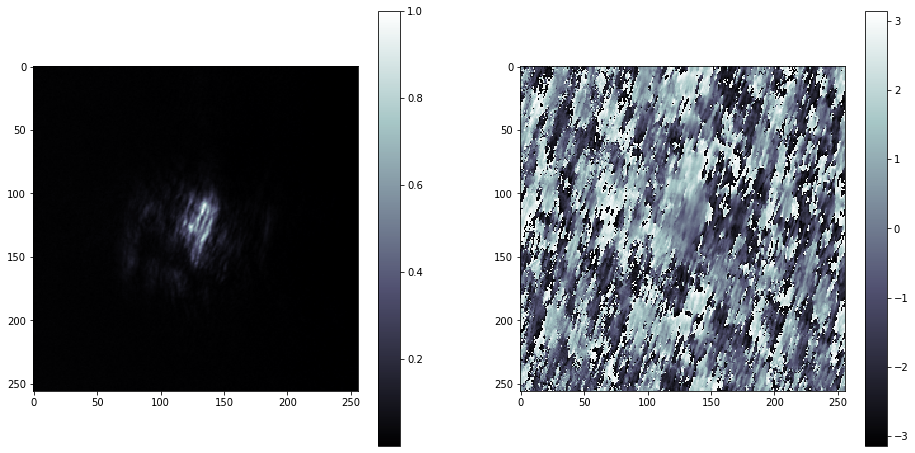

In [8]:
plt.rcParams['figure.figsize'] = 16,8
plt.figure(1)
for i in range(y_meas.shape[0]):
    plt.subplot(2,5,i+1)
    plt.imshow(abs(y_meas[i,:,:]), cmap='bone');plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
plt.figure(2)
for i in range(y_meas.shape[0]):
    plt.subplot(2,5,i+1)
    plt.imshow(np.angle(y_meas[i,:,:]), cmap='bone');plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
plt.figure(3)
plt.subplot(121)
plt.imshow(abs(y_holo), cmap='bone');plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(y_holo), cmap='bone');plt.colorbar()

Construct the microscope forward model

In [9]:
# Construct forward model
input_shape = (N,N,NZ)
fwd_op = ForwardModel(input_shape, mask, defocus=LZ/2, include_shg=True)

Solve the regularized least squares for the linear inverse problem

In [10]:
solver = LassoSolver(fwd_op, use_fista=False)
# x_init = fwd_op.adjoint(y_meas)/mask.num/NZ
x_init = holographic_recon(fwd_op.uscope, y_holo)
# xest,_,_ = solver.solve_fista(y_meas, n_iter=100,
#                    sparsifying="curvelets",
#                    print_recon=False,
#                    ground_truth=None)
xest = solver.solve_ista(y_meas,
                        x_init=x_init,
                        step=1.e-2,
                        lam=1.e-3,
                        imag_reg=0.,
                        n_iter=100,
                        step_scheduling=0.9999,
                        reg_scheduling=0.99,
                        sparsifying="curvelets",
                        print_recon=False,
                        verbose=False,
                        ground_truth=None)
final_mse = utils.mse(fwd_op(xest), y_meas)
print(final_mse)

0.0003941171112735491


In [ ]:
# Try different constant phase factors during reconstruction.
# xests = []
# final_losses = []
# const_phases = np.arange(10)*np.pi/10.

# for idx, phi0 in enumerate(const_phases):
#     print(idx, " : ", phi0)
#     xest = solver.solve_ista(y_meas*utils.cis(phi0),
#                             x_init=x_init,
#                             step=1.e-2,
#                             lam=1.e-3,
#                             n_iter=100,
#                             step_scheduling=0.9999,
#                             reg_scheduling=0.995,
#                             sparsifying="curvelets",
#                             print_recon=False,
#                             ground_truth=None)
#     xests.append(xest)
#     final_losses.append(solver.final_mse)
    

In [44]:
np.save("../results/Recon_tissue3d.npy", abs(xest)**2/(abs(xest)**2).max())

Display the results in 3D

In [57]:
X = fwd_op.uscope.spatial_grid['X']
Z = fwd_op.uscope.spatial_grid['Z']
x,y,z = np.meshgrid(X,Z,X)
tissue_recon = abs(xest[80:176,80:176,:])**2
tissue_recon = tissue_recon/tissue_recon.max()
tissue3d = mlab.pipeline.scalar_field(tissue_recon)

mlab.pipeline.volume(tissue3d, vmin=1.e-2, vmax=1, color=(0.2,1,0.2))
mlab.show()

![](tissue3d.png)

## Comparison with Holographic reconstruction
Next, we compare our reconstruction with partial holographic reconstruction from the electric field corresponding to $b_s$:


In [56]:
xhol = holographic_recon(fwd_op.uscope, y_holo)

![](tissue3d_hol.png)